# Metals with non-spin polarised calculations

### Import statements and custom functions

In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import pickle
from scipy import stats
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set()

In [311]:
def return_intersection(hist_1, hist_2):
    """Returns intersection of two sets of histogram data"""
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [312]:
def histo_mega_plot(df,element):
    """Plot set of histograms"""
    num_cols = len(df.columns.levels[1])
    fig, axs = plt.subplots(ncols=num_cols,figsize=(15,5))
    count = 0 
    for alpha in df.columns.levels[1]:
        sns.distplot(df[element][alpha].dropna(),
                     ax=axs[count]).set_title(element+' '+alpha)
        count += 1

In [313]:
def histo_mega_plot_2(df,element):
    """Plot set of histograms"""
    num_cols = len(df.columns.levels[1][0:3])
    fig, axs = plt.subplots(ncols=num_cols,figsize=(15,5))
    count = 0 
    for alpha in df.columns.levels[1][0:3]:
        sns.distplot(df[element][alpha].dropna(),
                     ax=axs[count],label=alpha).set_title(element+' '+alpha)
        sns.distplot(df[element]['no_spin'].dropna(),ax=axs[count],label='no_spin')
        axs[count].legend()
        count += 1

In [314]:
def compare_hist(df,bins=20):
    data = []
    for alpha in df.columns.levels[1][:-1]:
        for element in df.columns.levels[0]:
            a1,b,c = plt.hist(df[element][alpha],bins=bins,alpha=0.5)
            a2,b,c = plt.hist(df[element]['no_spin'],bins=bins,alpha=0.5)
            intersect = return_intersection(a1,a2)
            statistic , p_wilcox = stats.wilcoxon(a1,a2)
            statistic , p_ks = stats.ks_2samp(a1,a2)
            entropy = stats.entropy(a1, qk=a2, base=None)
            data.append([element,alpha,p_wilcox,p_ks,intersect,entropy])
    data = np.array(data,ndmin=2)
    comp_df = pd.DataFrame(data=data,columns=['element','alpha',
                                                   'p_wilcox','p_ks','intersect','entropy'])
    for i in ['p_wilcox','p_ks','intersect','entropy']:
        comp_df[i] = comp_df[i].astype('float')
    comp_df = comp_df.set_index(['element', 'alpha']).sort_index()
    return comp_df

## Load Data

In [315]:
# load spin data structure 
with open('./ferro_mag_extreme/data.obj','rb') as myfile:
     spin = pickle.load(myfile)
spin.pop('NiO',None)
pass

In [316]:
# load spin_pbe data structure 
with open('./ferro_magnetic_PBE/data.obj','rb') as myfile:
     spin_pbe = pickle.load(myfile)

In [317]:
# load no-spin data
with open('./non_spin_magnetic/data.obj','rb') as myfile:
     no_spin = pickle.load(myfile)

In [318]:
# Modified Slightly
# turn tripple nested dictionary into pandas data frame
def gen_df_from_dict_new(mag_dict_big):   
    mag_big_df = pd.DataFrame.from_dict({(i,j): mag_dict_big[i][j][0] 
                               for i in mag_dict_big.keys()
                               for j in mag_dict_big[i].keys()},
                               orient='index')
    # turn tuple columns into multiindex
    mag_big_df.index = pd.MultiIndex.from_tuples(mag_big_df.index)
    mag_big_df = mag_big_df.transpose()
    return mag_big_df

In [319]:
# add no_spin alphas to dictionary
# loop only over intersect
for element in (set(spin.keys()).intersection(no_spin.keys())):
    spin[element]['no_spin']=no_spin[element]['alpha_1']

In [320]:
# turn dictionary into dataFrame
alpha = gen_df_from_dict_new(spin)


# Histogram Analysis
Plot Histograms of all alpha sets for each element

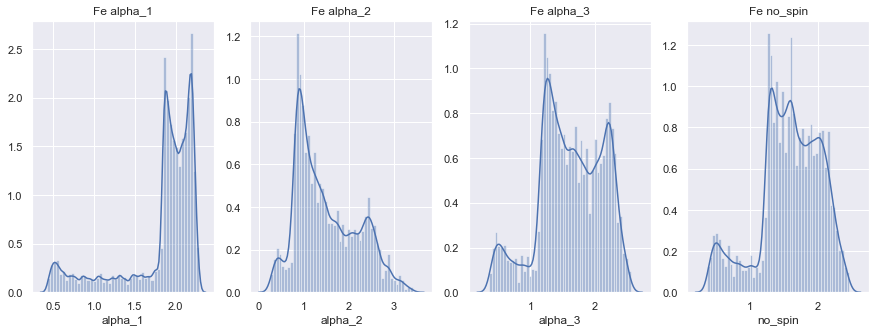

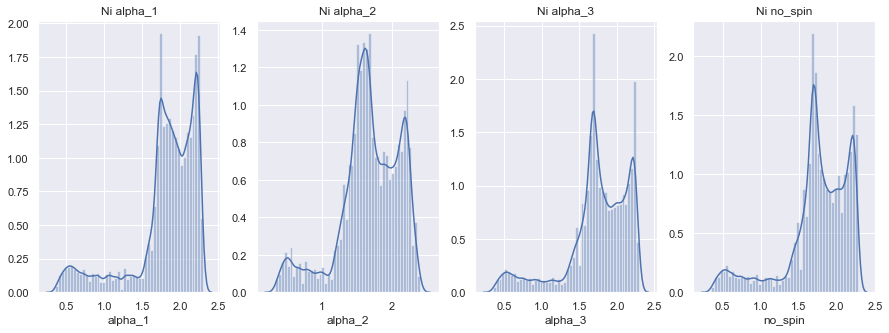

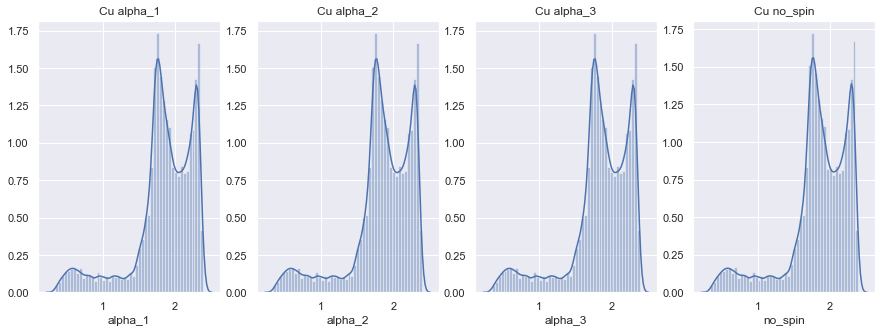

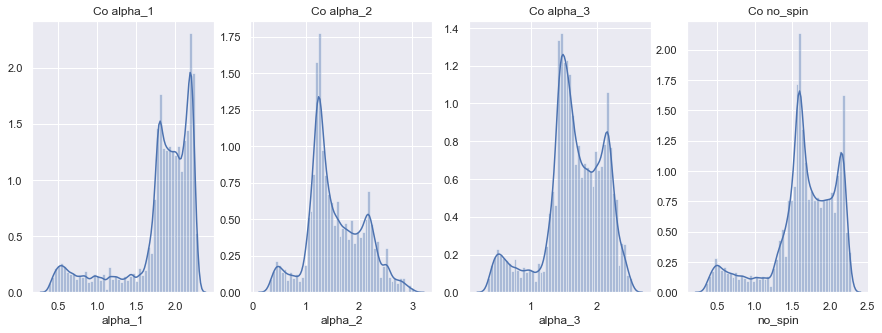

In [302]:
for element in set(spin.keys()).intersection(no_spin.keys()):
    histo_mega_plot(alpha,element)

### Overlay spin to no_spin
Re plot histograms but overlay the no_spin histogram over the three spin histograms

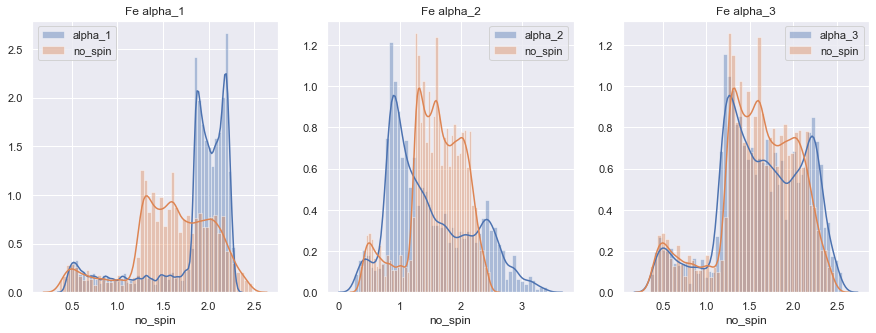

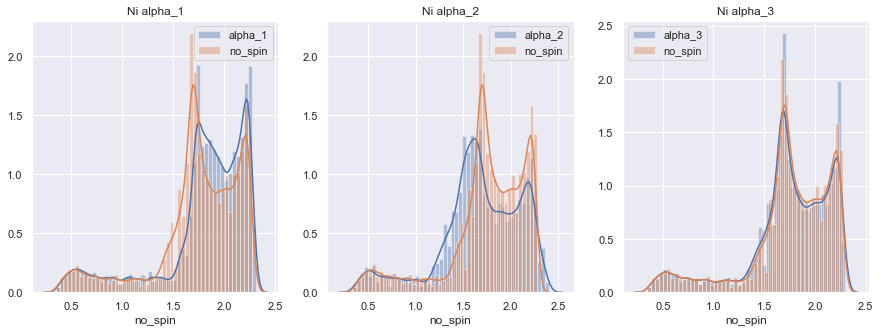

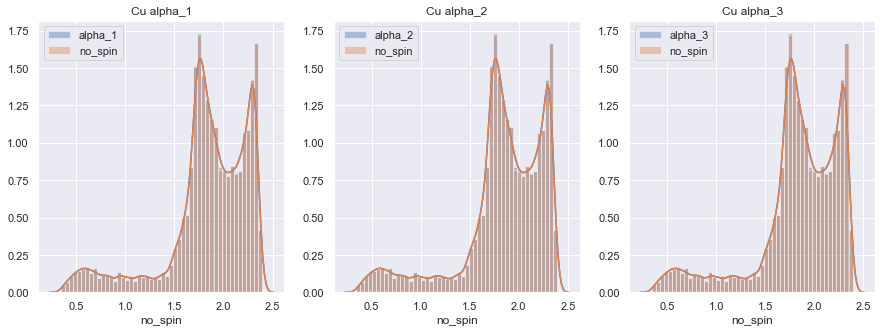

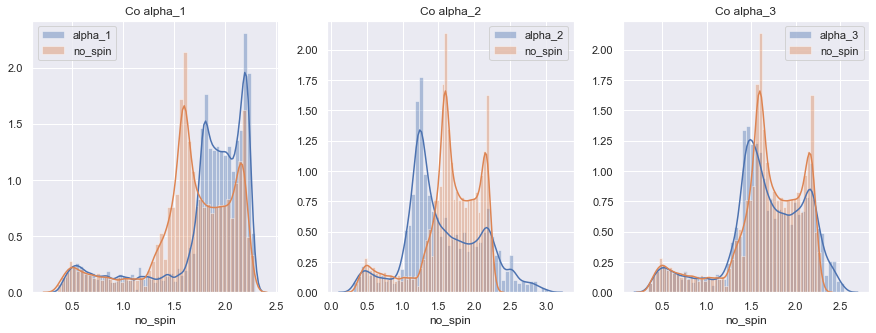

In [303]:
for element in set(spin.keys()).intersection(no_spin.keys()):
    histo_mega_plot_2(alpha,element)

### Observations
For all of the metals, histograms alpha_3 look the most similar to no_spin. I.e for the spin-pol calculation, the correlation alphas most closely resemble the alphas generated during a non-spin-pol calculation. 
In Fe, the difference between alpha_1 (up spin exchange) to no_spin is the most pronounced. 
In Cu, there appears to be almost no difference in any of the alpha sets. Is this expected, or is there something wrong with the CASTEP settings for these calculations?

# Statistical Analysis
apply a range of statistical tests to compare how close the spin-pol alphas are to the non-spin-pol alphas in each material.

p_wilcox      p_ks  intersect   entropy
element alpha                                           
Co      alpha_1  0.600834  0.497342   0.684006  0.293636
        alpha_2  0.681322  0.770953   0.493549  1.008540
        alpha_3  0.779463  0.965485   0.707583  0.311320
Cu      alpha_1  1.000000  1.000000   0.997750  0.000058
        alpha_2  1.000000  1.000000   0.997750  0.000058
        alpha_3  1.000000  1.000000   0.997750  0.000058
Fe      alpha_1  0.793839  0.275269   0.477559  0.798382
        alpha_2  0.667659  0.497342   0.536544  0.799945
        alpha_3  0.375980  0.497342   0.863297  0.132992
Ni      alpha_1  0.481151  0.965485   0.868913  0.060189
        alpha_2  0.903898  0.770953   0.704668  0.302308
        alpha_3  0.670066  0.999898   0.927598  0.016266

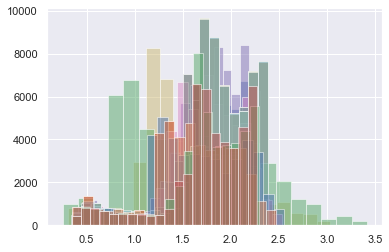

In [304]:
comp_df = compare_hist(alpha,bins=20)
comp_df

### Observations (bins = 20)
All of the metrics confirm that for Cu, all the alpha distributions are essentially identical. 
For all materials, except Cu, the overlap between alpha_3 and no_spin is the largest, and the entropy is the lowest. This indicates that these distributions are most similar. For Fe, alpha_1 has the lowest overlap overlap of all values. For Co, alpha_1 and alpha_2 als differ significantly from no_spin. 

### Effect of changing number of bins

In [305]:
import warnings
warnings.filterwarnings('ignore')

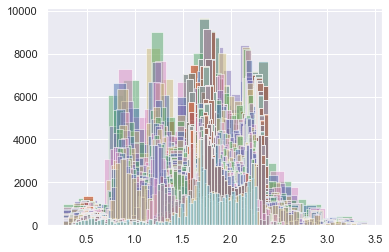

In [242]:
# generate statistical metrics for different number of histogram bins
list_of_df = []
for bins in range(20,60,2):
    temp_df = compare_hist(alpha,bins=bins)
    list_of_df.append(temp_df)

In [306]:
# reformat above data into df for each metric and each alpha
metric_dict_list = []
for alpha in ['alpha_1','alpha_2','alpha_3']:
    metric_dict = {}
    for metric in ['p_wilcox', 'p_ks','intersect','entropy']:   
        temp_dict = {}
        for element in ['Co','Fe','Ni','Cu']:
            temp_list = []
            for df in list_of_df:
                temp_list.append(df.loc[element,metric].loc[alpha])
            temp_dict[element]=temp_list/max(temp_list)

        temp_df = pd.DataFrame.from_dict(temp_dict)
        temp_df['bins']=range(20,60,2)
        #temp_df= temp_df.set_index('bins')
        metric_dict[metric]=temp_df
    metric_dict_list.append(metric_dict)

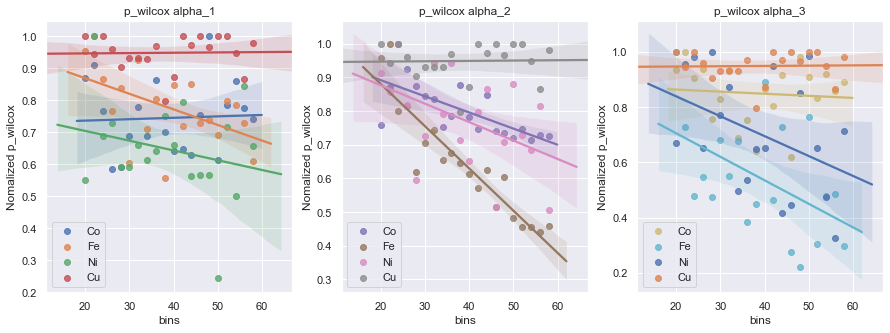

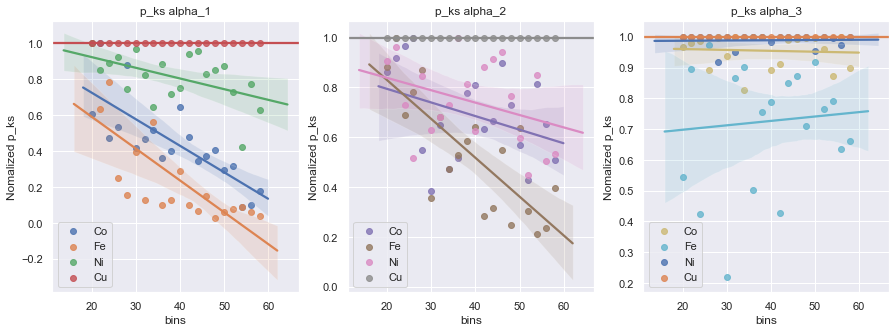

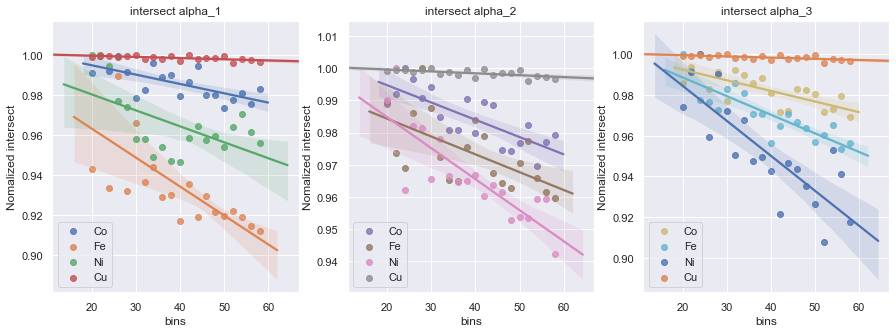

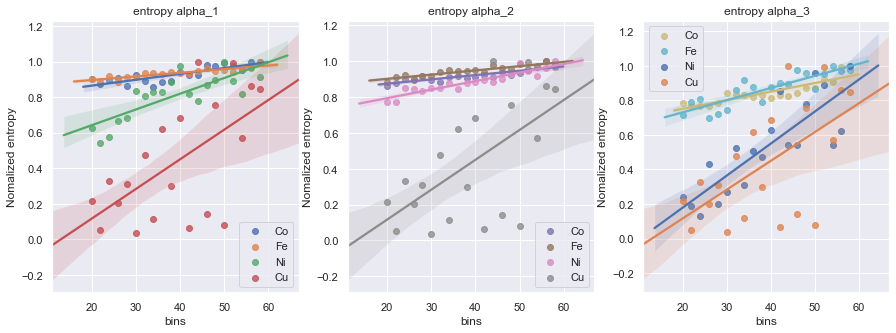

In [327]:
# plot everything
for metric in ['p_wilcox', 'p_ks','intersect','entropy']:
    fig, axs = plt.subplots(ncols=3,figsize=(15,5))
    for i in range(0,3):
        for element in metric_dict_list[i][metric].columns.drop('bins'):
            sns.regplot(data=metric_dict_list[i][metric],x='bins',y=element,label=element,ax=axs[i]).set_title(metric+' alpha_'+str(i+1))
            #axs[i].ylabel("Normalized "+metric)
            axs[i].set(ylabel='Nomalized '+metric)
            axs[i].legend()

### Observations
Based on the changes in statistical metrics with number of bins in histograms, the p-values from Wilcoxon ranked sum test and Kolmogorov-Smirnov test are strongly dependent on the number of bins. This makes them an unreliable metric for comparing the different alpha distributions. On the other hand, the intresect is a very strong metric as it is only slightly affected by the bin size. The entropy for most of the systems is also a stong metric, whith the exception of Cu for all alphas and Ni for alpha_3.